In [1]:
import jittor as jt
from jittor import nn, Module
from jittor.dataset.cifar import CIFAR10
import jittor.transform as trans
from model import Model
import sys, os
import random
import math
from jittor import init
import numpy as np
from jittor.dataset import DataLoader
#继承类实现对数据的删减
class moderated_Cifar10(CIFAR10):
    def __init__(self, root=None, train=True, transform=None, download=False):
        super().__init__(root, train=train, transform = transform, download=download)
        cnt = [0, 0, 0, 0, 0]
        indices = []
        for index, label in enumerate(self.targets):
            if label < 5:
                if cnt[label] < 500: #标签0-4的保留500个
                    indices.append(index)
                    cnt[label] += 1
            else:
                indices.append(index)
        self.targets = [self.targets[i] for i in range(50000) if i in indices]
        mask = np.zeros(50000, dtype=bool)
        mask[indices] = True
        self.data = self.data[mask]

jt.set_seed(42)
trainlos = []
#定义训练函数
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        outputs = model(inputs)
        loss = nn.cross_entropy_loss(outputs, targets)
        optimizer.step (loss)
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx*100, len(train_loader),
                100. * batch_idx / len(train_loader), loss.data[0]))
        trainlos.append(loss.data[0])
#定义测试函数
def test(model, val_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total_acc = 0
    total_num = 0
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        batch_size = inputs.shape[0]
        outputs = model(inputs)
        pred = np.argmax(outputs.data, axis=1)
        acc = np.sum(targets.data==pred)
        total_acc += acc
        total_num += batch_size
        acc = acc / batch_size
        print('Test Epoch: {} [{}/{} ({:.0f}%)]\tAcc: {:.6f}'.format(epoch, \
                    batch_idx, len(val_loader),100. * float(batch_idx) / len(val_loader), acc))
    print ('Total test acc =', total_acc / total_num)

        
def main():
    batch_size = 100
    learning_rate = 0.01
    momentum = 0.9
    weight_decay = 1e-2
    epochs = 5
    transform_train = trans.Compose([trans.RandomHorizontalFlip(0.5), trans.ImageNormalize(mean = [0.5], std = [0.2])])
    transform_test = trans.Compose([trans.ImageNormalize(mean = [0.5], std = [0.2])])
    batch_size=100
    '''
    在未删减的数据集上使用则改为改数据集
    dataset_train = CIFAR10(root='cifar-10-python', train=True, transform=transform_train,  download=False).set_attrs(batch_size=batch_size, shuffle=True)  
    dataset_valid = CIFAR10(root='cifar-10-python', train=False, transform=transform_test, download=False).set_attrs(batch_size=batch_size,   shuffle=False
    '''
    dataset_train = moderated_Cifar10(root='cifar-10-python', train=True, transform=transform_train,  download=False)
    dataset_valid = CIFAR10(root='cifar-10-python', train=False, transform=transform_test, download=False)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size,shuffle = True, num_workers = 0)
    dataloader_test = DataLoader(dataset_valid, batch_size=batch_size,shuffle = False, num_workers = 0)
    model = Model()
    optimizer = nn.SGD(model.parameters(), learning_rate, momentum, weight_decay)
    for epoch in range(epochs):
        train(model, dataloader_train, optimizer, epoch)
        test(model,dataloader_test,epoch)

if __name__ == '__main__':
    main()

27500
Train Epoch: 0 [0/27500 (0%)]	Loss: 2.416462
Train Epoch: 0 [100/27500 (0%)]	Loss: 2.281726
Train Epoch: 0 [200/27500 (0%)]	Loss: 2.060023
Train Epoch: 0 [300/27500 (0%)]	Loss: 1.863380


KeyboardInterrupt: 

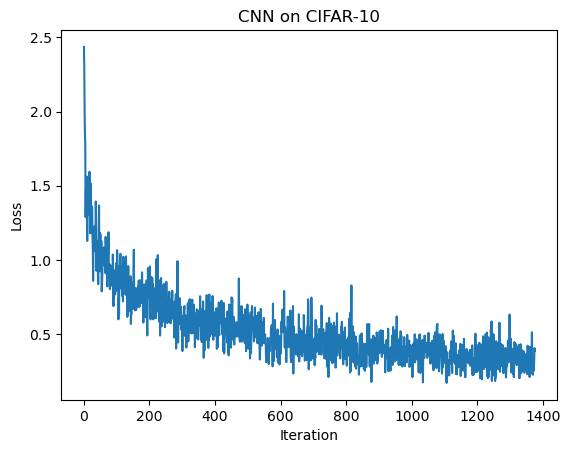

In [2]:
#画图
import matplotlib.pyplot as plt
x = np.linspace(1,1375,1375)
plt.plot(x, trainlos)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('CNN on CIFAR-10')
plt.show()

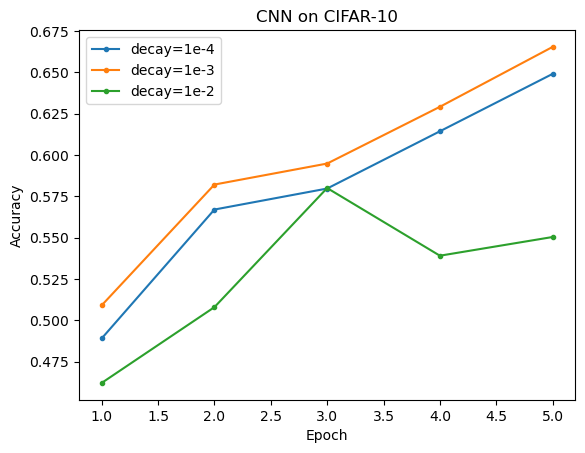

In [11]:
#画测试集准确率
x = [1, 2, 3, 4, 5]
y_4 = [0.4891,0.567,0.5797,0.6143,0.649]
y_3 = [0.5091,0.5821,0.5948,0.6291,0.6653]
y_2 = [0.4622,0.508,0.58,0.5391,0.5504]
plt.plot(x, y_4,marker='o', markersize=3)
plt.plot(x, y_3,marker='o', markersize=3)
plt.plot(x, y_2,marker='o', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN on CIFAR-10')
plt.legend(['decay=1e-4', 'decay=1e-3','decay=1e-2'])
plt.show()